In [1]:
# Importing the necessary lib
import pandas as pd
import seaborn as sns
import numpy as np
import pyreadr as py # library to read .Rdata files in python
import sqlite3
import os
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix,confusion_matrix,classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV,KFold
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer,one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, BatchNormalization,concatenate,Flatten,MaxPool2D,Embedding,Dense,Dropout,MaxPooling2D,Reshape,BatchNormalization
from keras.models import Sequential
from keras import Model,Input
from keras.layers.convolutional import Conv2D,Conv1D
import keras.backend as k
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score,f1_score,log_loss,recall_score,classification_report
import tensorflow as tf
from keras.callbacks import Callback, EarlyStopping
from time import time
from scipy.sparse import hstack
from tensorflow.python.keras.callbacks import TensorBoard
import pickle
from keras.optimizers import Adam,SGD,RMSprop
from keras.initializers import RandomUniform,he_uniform,glorot_normal
from keras.regularizers import l1
from keras.models import Sequential
from keras.layers import LSTM,BatchNormalization
from keras.layers.core import Dense, Dropout
import datetime
from prettytable import PrettyTable
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform,pchoice
from keras.utils import to_categorical
from keras.regularizers import l1
import warnings
warnings.filterwarnings("ignore")

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#REading the train, test and CV data
train = pd.read_csv('train.csv')
cv = pd.read_csv("cv.csv")
test = pd.read_csv("test.csv")
train.head()

,Unnamed: 0,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0,0.0,1.0,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,1,0.0,1.0,2,0.25109,3659.4,4556.6,9.4264,26.721,42.576,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,2,0.0,1.0,3,0.25038,3660.3,4477.8,9.4426,26.875,42.070,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,3,0.0,1.0,4,0.24977,3661.3,4512.1,9.4776,26.758,42.063,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,4,0.0,1.0,5,0.29405,3679.0,4497.0,9.3381,26.889,42.650,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461


In [3]:
#Sorting the Datasets wrt to the simulation runs
train.sort_values(['simulationRun','faultNumber'],inplace = True)
test.sort_values(['simulationRun','faultNumber'],inplace = True)
cv.sort_values(['simulationRun','faultNumber'],inplace = True)

### References:

- Mihajlo Grbovic et.al "Cold start approach for data - driven fault detection", IEEE Transactions on Industrial Informatics, November 2013.

- Mohamed Bin Shams et .al "Fault Detection using CUMSUM based techniques with application to the Tennessee Eastman Process", Proceedings of the 9th International Symposium on Dynamics and control of Process Systems.

- Danfeng Xie et .al " Deep Learning in Visual Computing and Signal Processing", Review Article, Applied Computation Intelligence and Soft computing, Volume 2017,Article ID 1320780

From the above references, its being noted that fault 3,9 and 15 are very difficult to detect and hence we will ignore fault 3, 9 and 15 for our models.

# Performance Metric :

- FDR : Fault Detection Rate, is the ratio of number of samples predicted in the i^th class to the total number of samples predicted in the i^th class and other class. That is basically we need to have high precision for each fault.





In [4]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [0,1,2,4,5,6,7,8,10,11,12,13,14,16,17,18,19,20]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(20,20))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(20,20))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(20,20))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

In [5]:
# Removing faults 3,9 and 15 
tr = train.drop(train[(train.faultNumber == 3) | (train.faultNumber == 9) | (train.faultNumber == 15)].index).reset_index()
ts = test.drop(test[(test.faultNumber == 3) | (test.faultNumber == 9) | (test.faultNumber == 15)].index).reset_index()
cv_ = cv.drop(cv[(cv.faultNumber == 3) | (cv.faultNumber == 9) | (cv.faultNumber == 15)].index).reset_index()

In [ ]:
#converting the class labels to categorical values and removing unnecessary features from train, test and cv data.
y_train = to_categorical(tr['faultNumber'],num_classes=21)
y_test = to_categorical(ts['faultNumber'],num_classes=21)
y_cv = to_categorical(cv_['faultNumber'],num_classes=21)
tr.drop(['faultNumber','Unnamed: 0','simulationRun','sample','index'],axis=1,inplace=True)
ts.drop(['faultNumber','Unnamed: 0','simulationRun','sample','index'],axis =1,inplace=True)
cv_.drop(['faultNumber','Unnamed: 0','simulationRun','sample','index'],axis =1,inplace=True)

In [10]:
# REsizing the train, test and cv data.
x_train = np.resize(tr,(183200,52,1))
x_test = np.resize(ts,(89000,52,1))
x_cv = np.resize(cv_,(93440,52,1))

# Deep Learning Models
# In model -1 and model -2 we will be Training the LSTM models with one row at a time from the train dataset. Each row or sample has 52 features.

# Model - 1

In [20]:
model = Sequential()
model.add(LSTM(256,input_shape= (52,1),return_sequences= True))
model.add(LSTM(128,return_sequences= False))
#model.add(LSTM(64,return_sequences= False))
#model.add(Flatten())
#model.add(BatchNormalization())
#model.add(Flatten())
model.add(Dense(300))
model.add(Dropout(0.5))
model.add(Dense(128))
#model.add(Dense(64))
#model.add(BatchNormalization())
#model.add(Dropout(0.6))
model.add(Dense(21,activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 52, 256)           264192    
_________________________________________________________________
lstm_16 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dense_16 (Dense)             (None, 300)               38700     
_________________________________________________________________
dropout_9 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               38528     
_________________________________________________________________
dense_18 (Dense)             (None, 21)                2709      
Total params: 541,249
Trainable params: 541,249
Non-trainable params: 0
_________________________________________________________________
None

In [15]:
model.fit(x_train, y_train, nb_epoch=50,verbose=2,batch_size=256,validation_data = (x_cv,y_cv))

Train on 183200 samples, validate on 93440 samples
Epoch 1/50
 - 162s - loss: 1.0927 - acc: 0.6318 - val_loss: 1.0590 - val_acc: 0.6751
Epoch 2/50
 - 165s - loss: 1.0491 - acc: 0.6514 - val_loss: 1.0237 - val_acc: 0.6901
Epoch 3/50
 - 161s - loss: 0.9332 - acc: 0.6871 - val_loss: 0.9558 - val_acc: 0.7099
Epoch 4/50
 - 162s - loss: 0.8907 - acc: 0.6994 - val_loss: 0.9719 - val_acc: 0.6908
Epoch 5/50
 - 162s - loss: 0.8844 - acc: 0.7011 - val_loss: 0.9301 - val_acc: 0.7209
Epoch 6/50
 - 162s - loss: 0.8599 - acc: 0.7092 - val_loss: 0.8876 - val_acc: 0.7305
Epoch 7/50
 - 162s - loss: 0.8418 - acc: 0.7150 - val_loss: 0.9074 - val_acc: 0.7281
Epoch 8/50
 - 162s - loss: 0.8327 - acc: 0.7175 - val_loss: 0.9207 - val_acc: 0.7139
Epoch 9/50
 - 162s - loss: 0.8346 - acc: 0.7173 - val_loss: 0.8743 - val_acc: 0.7315
Epoch 10/50
 - 162s - loss: 0.8129 - acc: 0.7233 - val_loss: 0.8888 - val_acc: 0.7299
Epoch 11/50
 - 163s - loss: 0.8098 - acc: 0.7245 - val_loss: 0.9028 - val_acc: 0.7152
Epoch 12/50


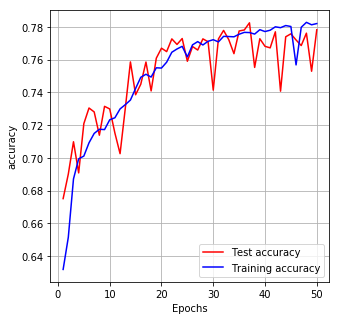

Test accuracy: 0.7455730337078652
Test loss: 0.8368957242772412


In [16]:
model_paras = model.history
x = list(range(1,len(model_paras.history['loss']) + 1))
plt.figure(figsize=(5,5))
plt.plot(x,model_paras.history['val_acc'],color = 'r',label = 'Test accuracy')
plt.plot(x,model_paras.history['acc'],color = 'b',label = 'Training accuracy')
plt.grid()
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.show()
# Final evaluation of the model
#scores = model.evaluate(x_test, y_test, verbose=0)
#print("Accuracy: %.2f%%" % (scores[1]*100))
score, acc = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy:', acc)
print("Test loss:", score)

Number of misclassified points  25.442696629213486
-------------------------------------------------- Confusion matrix --------------------------------------------------


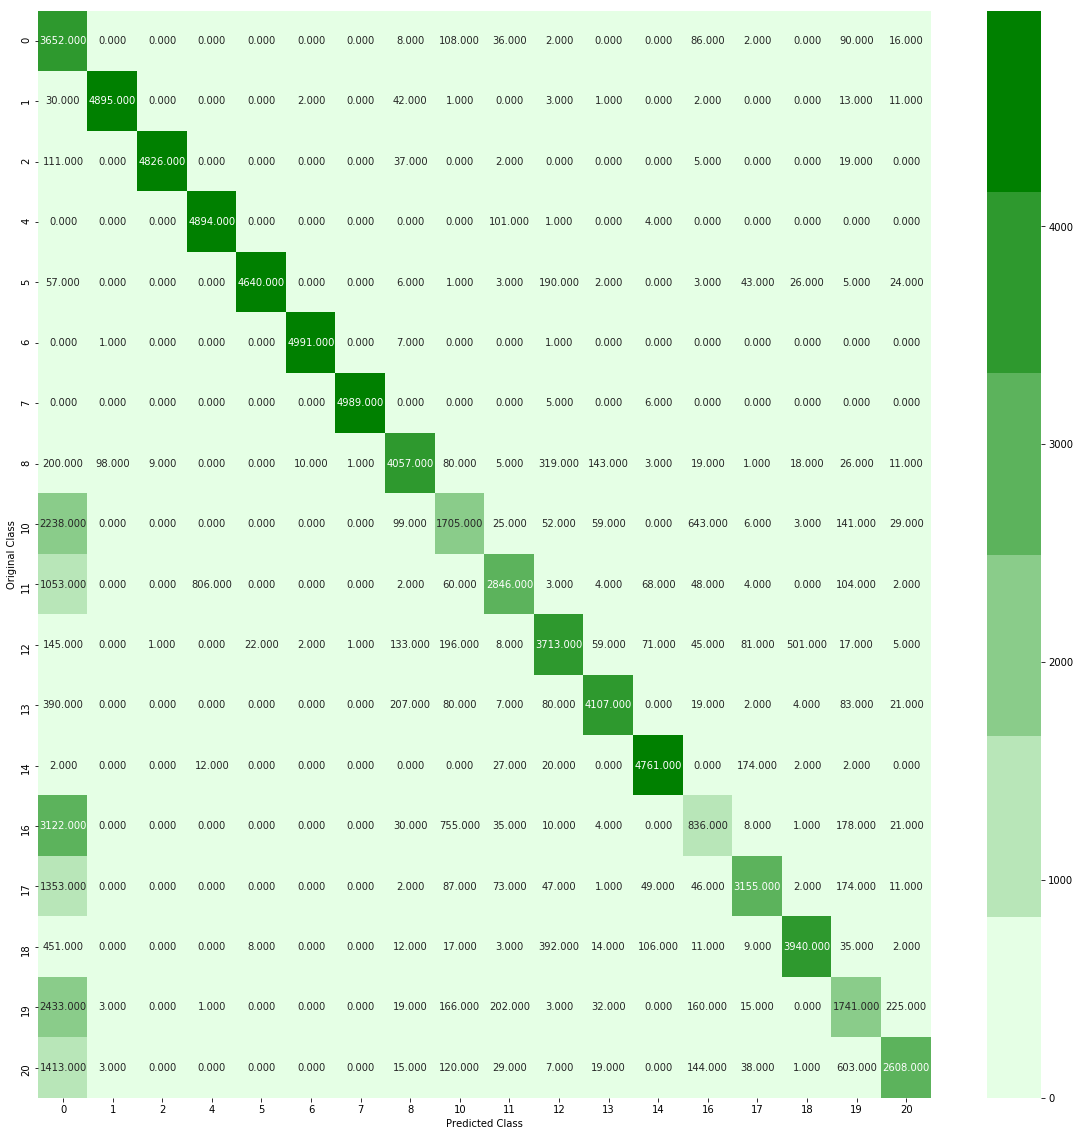

-------------------------------------------------- Precision matrix --------------------------------------------------


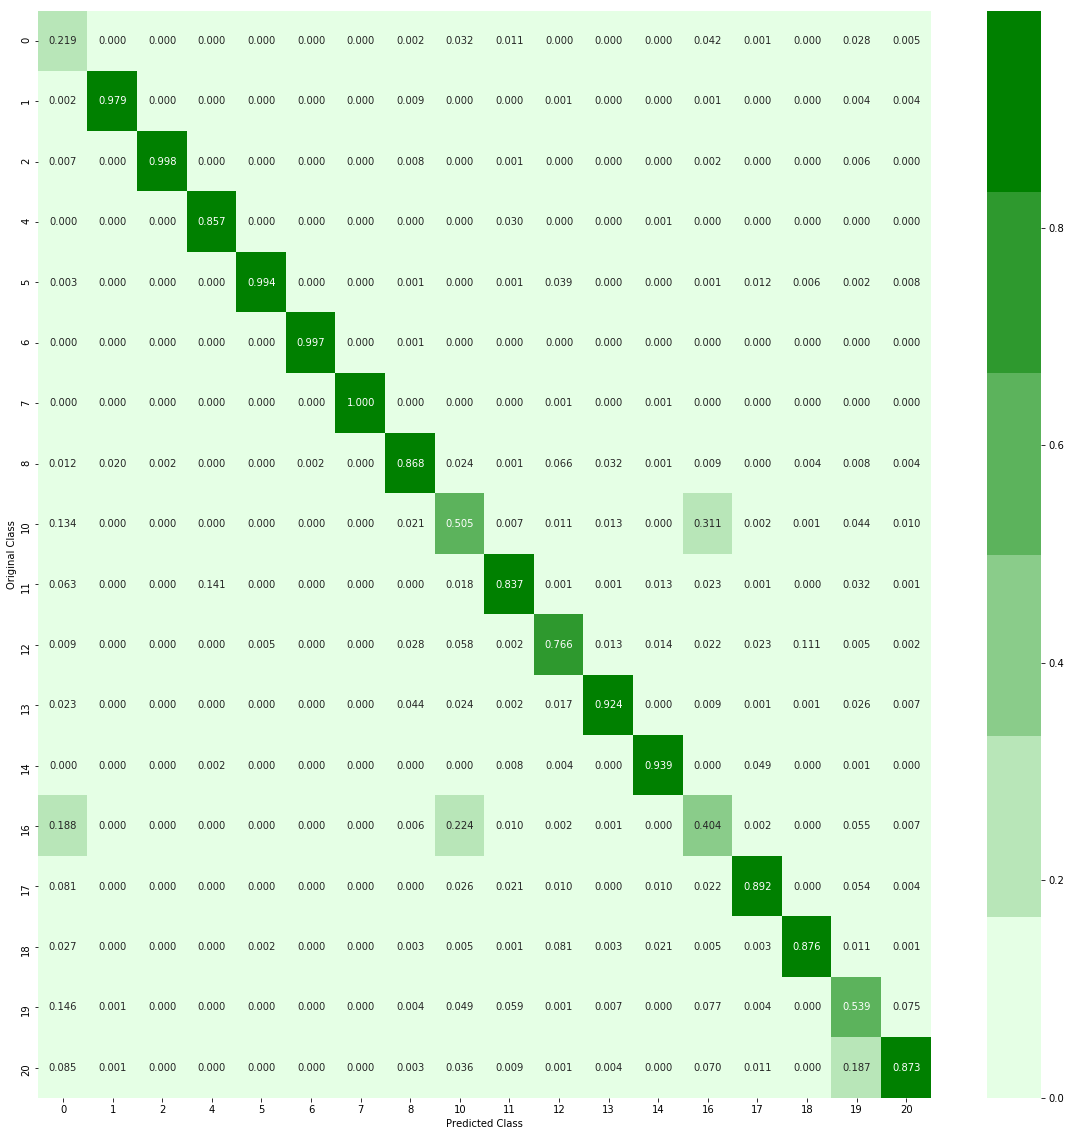

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


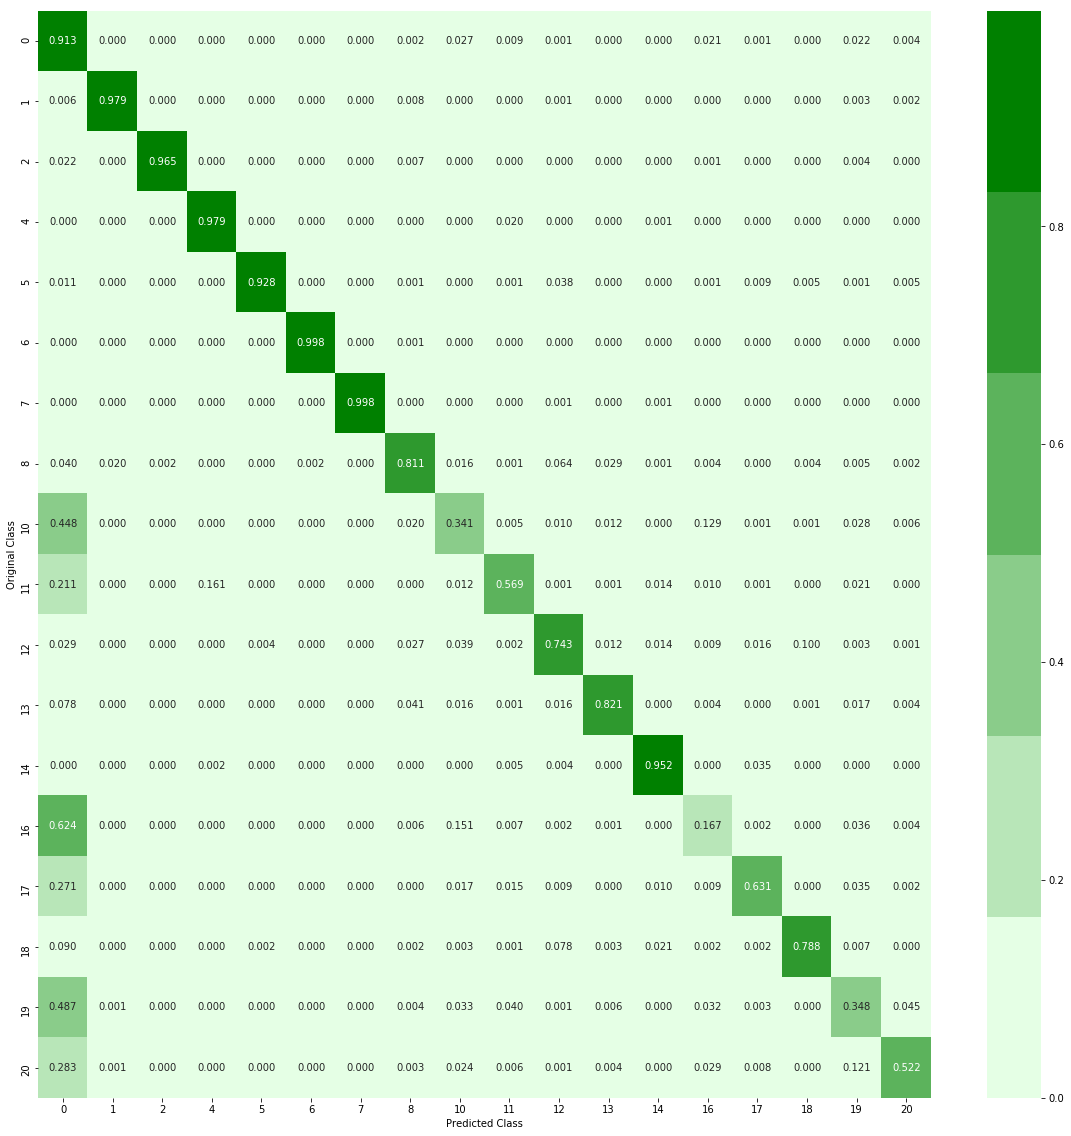

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [17]:
y = model.predict_proba(x_test)
plot_confusion_matrix(np.argmax(y_test,axis = 1),np.argmax(y,axis = 1))

# Model 2

In [17]:
model = Sequential()
model.add(LSTM(128,input_shape = (52,1),return_sequences=False))
#model.add(LSTM(128,return_sequences= False))
#model.add(LSTM(64,return_sequences= False))
#model.add(BatchNormalization())
#model.add(Flatten())

model.add(Dense(300))
model.add(Dropout(0.5))
model.add(Dense(128))
#model.add(Dense(64))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))
model.add(Dense(21,activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_10 (Dense)             (None, 300)               38700     
_________________________________________________________________
dropout_4 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               38528     
_________________________________________________________________
dense_12 (Dense)             (None, 21)                2709      
Total params: 146,497
Trainable params: 146,497
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
model.fit(x_train, y_train, nb_epoch=50,verbose=2,batch_size=256,validation_data = (x_cv,y_cv))

Train on 183200 samples, validate on 93440 samples
Epoch 1/50
 - 70s - loss: 1.9552 - acc: 0.3805 - val_loss: 1.5638 - val_acc: 0.5450
Epoch 2/50
 - 71s - loss: 1.4338 - acc: 0.5242 - val_loss: 1.3573 - val_acc: 0.5908
Epoch 3/50
 - 71s - loss: 1.3135 - acc: 0.5583 - val_loss: 1.2570 - val_acc: 0.6212
Epoch 4/50
 - 71s - loss: 1.2581 - acc: 0.5752 - val_loss: 1.2673 - val_acc: 0.6150
Epoch 5/50
 - 70s - loss: 1.2316 - acc: 0.5823 - val_loss: 1.2462 - val_acc: 0.6193
Epoch 6/50
 - 71s - loss: 1.1949 - acc: 0.5972 - val_loss: 1.2274 - val_acc: 0.6244
Epoch 7/50
 - 71s - loss: 1.1326 - acc: 0.6177 - val_loss: 1.1179 - val_acc: 0.6644
Epoch 8/50
 - 70s - loss: 1.0935 - acc: 0.6292 - val_loss: 1.0732 - val_acc: 0.6774
Epoch 9/50
 - 71s - loss: 1.0670 - acc: 0.6381 - val_loss: 1.0716 - val_acc: 0.6793
Epoch 10/50
 - 73s - loss: 1.0380 - acc: 0.6456 - val_loss: 1.1222 - val_acc: 0.6633
Epoch 11/50
 - 73s - loss: 1.0381 - acc: 0.6479 - val_loss: 1.0755 - val_acc: 0.6724
Epoch 12/50
 - 73s - lo

Number of misclassified points  26.42808988764045
-------------------------------------------------- Confusion matrix --------------------------------------------------


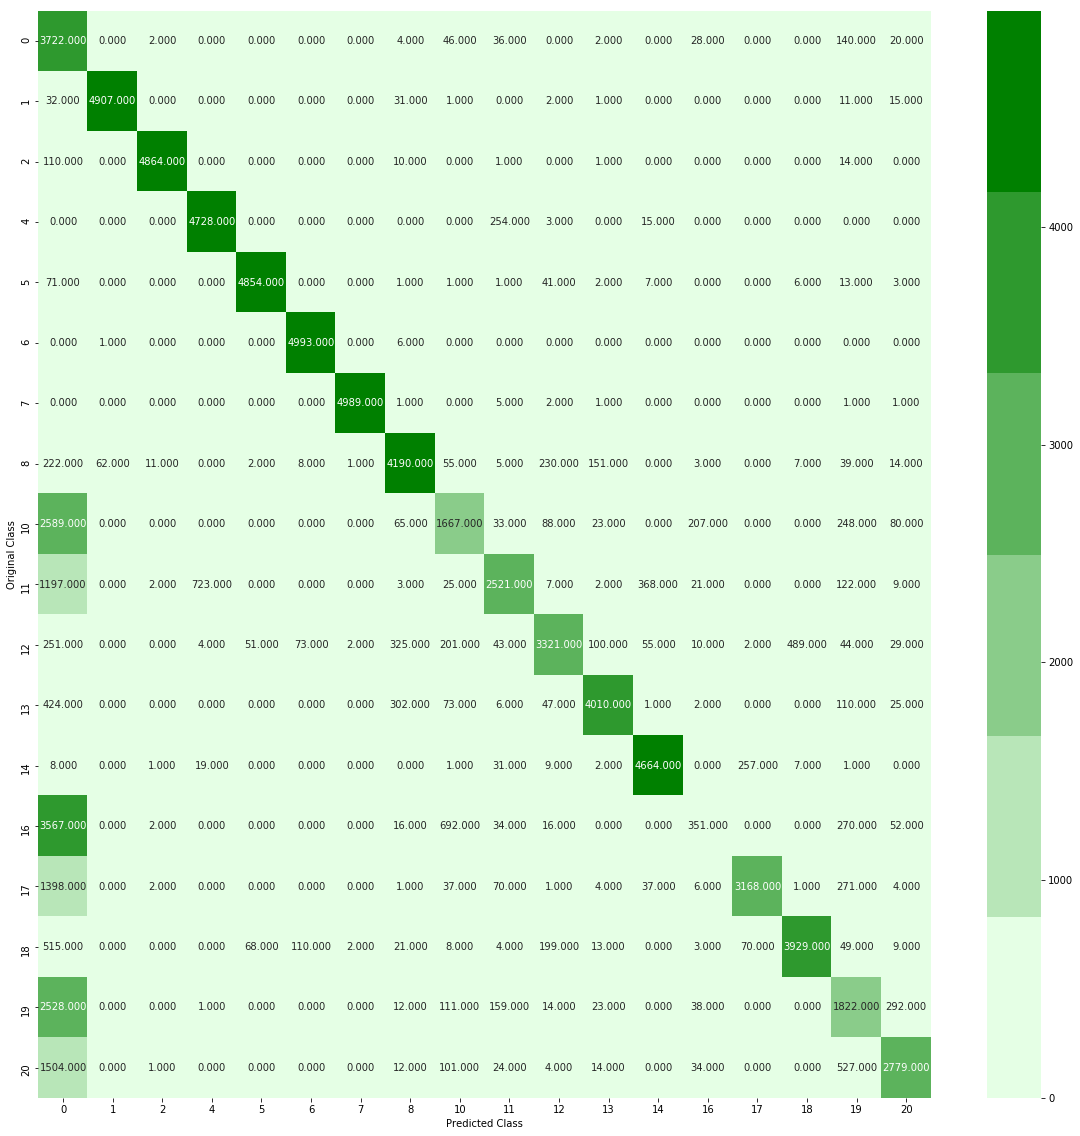

-------------------------------------------------- Precision matrix --------------------------------------------------


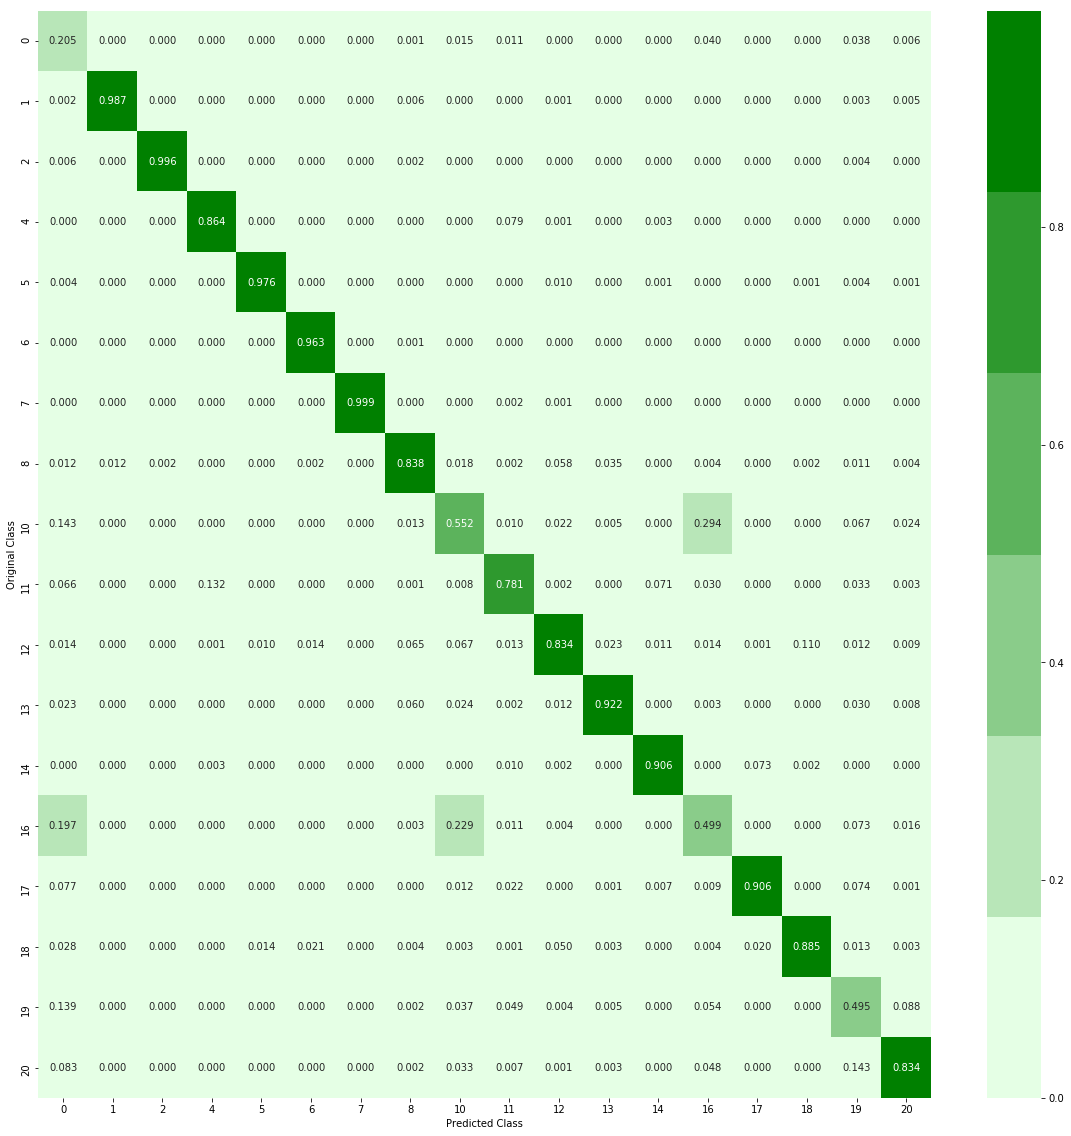

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


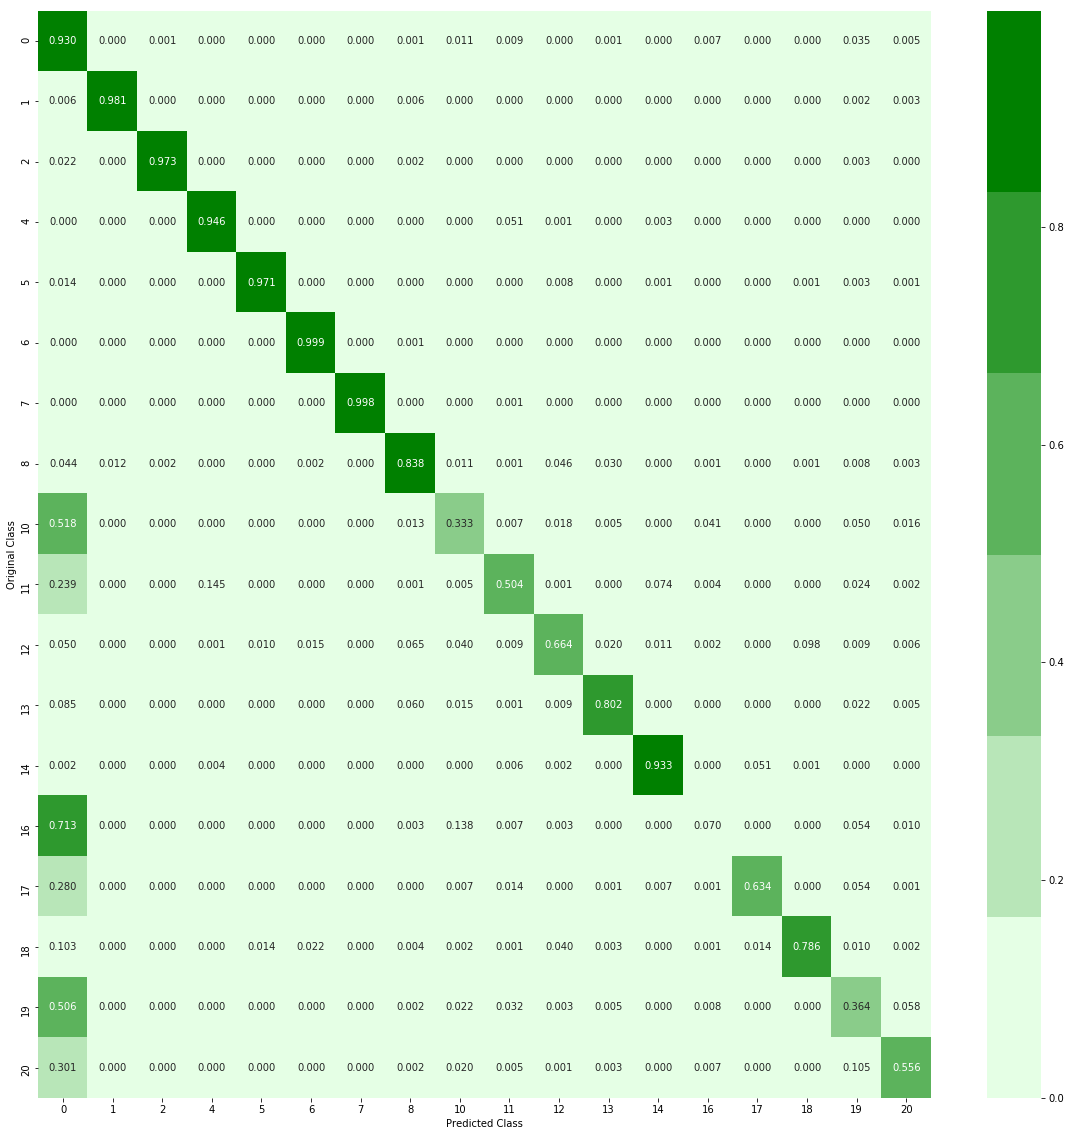

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [21]:
y = model.predict_proba(x_test)
plot_confusion_matrix(np.argmax(y_test,axis = 1),np.argmax(y,axis = 1))

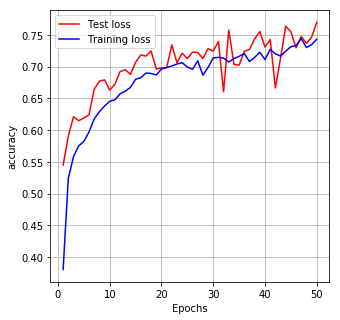

Test accuracy: 0.7357191011235955
Test loss: 0.826636850212992


In [22]:
model_paras = model.history
x = list(range(1,len(model_paras.history['loss']) + 1))
plt.figure(figsize=(5,5))
plt.plot(x,model_paras.history['val_acc'],color = 'r',label = 'Test loss')
plt.plot(x,model_paras.history['acc'],color = 'b',label = 'Training loss')
plt.grid()
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.show()
# Final evaluation of the model
#scores = model.evaluate(x_test, y_test, verbose=0)
#print("Accuracy: %.2f%%" % (scores[1]*100))
score, acc = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy:', acc)
print("Test loss:", score)

# Train , Test and CV data pre processing for Deep learning models

- Since fault is introduced at one hour of each simulation, let us train the LSTM models with 20 samples at a time. So in model 3 and model 4, each input to the model will have 20 samples of 52 Dim from the train dataset.

In [5]:
#Transformig the class labels of train, test and cv. Every 20th point is sampled.
label_train = []
for row in range(9160):
   
    label_train.append(tr['faultNumber'][row * 20])

    
label_test = []
for row in range(4450):
   
    label_test.append(ts['faultNumber'][row * 20])
    
label_cv = []
for row in range(4672):
    label_cv.append(cv['faultNumber'][row * 20])

In [7]:
#Transforming the train, test and cv data, to get an array of shape (20,52)
tr_ = tr.values
tr_arr = np.empty([9160,20,52])
for x in range(9160):
    tr_arr[x] = tr_[20 * x : 20+20*x]

#ts_ = norm.transform(ts.values)
ts_ = ts.values
ts_arr = np.empty([4450,20,52])

for x in range(4450):
    ts_arr[x] = ts_[20 * x : 20+20*x]

#cv_ar = norm.transform(cv_.values)
cv_ar = cv_.values
cv_arr = np.empty([4672,20,52])
for x in range(4672):
    cv_arr[x] = cv_ar[20 * x : 20+20*x]
     

In [9]:
y_train = to_categorical(label_train,num_classes=21)
y_test = to_categorical(label_test,num_classes=21)
y_cv = to_categorical(label_cv,num_classes=21)


In [74]:
x_train = np.transpose(tr_arr,(0,2,1))
x_test = np.transpose(ts_arr,(0,2,1))
x_cv = np.transpose(cv_arr,(0,2,1))
#x_test.shape

# Model - 3

In [93]:
model = Sequential()
model.add(LSTM(128,input_shape=(52, 20),return_sequences= True,activation = 'sigmoid'))
#model.add(LSTM(256,return_sequences= True))
model.add(LSTM(128,return_sequences= False,activation = 'sigmoid'))
#model.add(LSTM(64,return_sequences= False))
#model.add(Flatten())
#model.add(BatchNormalization())
#model.add(Flatten())
model.add(Dense(300))
model.add(Dropout(0.5))
model.add(Dense(128))
#model.add(Dense(64))
model.add(Dropout(0.8))
model.add(BatchNormalization())

model.add(Dense(21,activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_55 (LSTM)               (None, 52, 128)           76288     
_________________________________________________________________
lstm_56 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_73 (Dense)             (None, 300)               38700     
_________________________________________________________________
dropout_38 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_74 (Dense)             (None, 128)               38528     
_________________________________________________________________
dropout_39 (Dropout)         (None, 128)               0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 128)               512       
__________

In [98]:
model.fit(x_train, y_train, nb_epoch=50,verbose=2,batch_size=256,validation_data = (x_test,y_test))

Train on 9160 samples, validate on 4450 samples
Epoch 1/50
 - 7s - loss: 0.6691 - acc: 0.7608 - val_loss: 0.7341 - val_acc: 0.7364
Epoch 2/50
 - 7s - loss: 0.6649 - acc: 0.7653 - val_loss: 0.7308 - val_acc: 0.7396
Epoch 3/50
 - 7s - loss: 0.6929 - acc: 0.7603 - val_loss: 0.7758 - val_acc: 0.7247
Epoch 4/50
 - 7s - loss: 0.6823 - acc: 0.7578 - val_loss: 0.7441 - val_acc: 0.7411
Epoch 5/50
 - 7s - loss: 0.6838 - acc: 0.7593 - val_loss: 0.7333 - val_acc: 0.7400
Epoch 6/50
 - 7s - loss: 0.6763 - acc: 0.7616 - val_loss: 1.3449 - val_acc: 0.6153
Epoch 7/50
 - 7s - loss: 0.7363 - acc: 0.7442 - val_loss: 0.7561 - val_acc: 0.7402
Epoch 8/50
 - 8s - loss: 0.6867 - acc: 0.7608 - val_loss: 0.7651 - val_acc: 0.7312
Epoch 9/50
 - 7s - loss: 0.6719 - acc: 0.7662 - val_loss: 0.7323 - val_acc: 0.7407
Epoch 10/50
 - 7s - loss: 0.6543 - acc: 0.7702 - val_loss: 0.7566 - val_acc: 0.7351
Epoch 11/50
 - 7s - loss: 0.6539 - acc: 0.7714 - val_loss: 0.7666 - val_acc: 0.7449
Epoch 12/50
 - 7s - loss: 0.6567 - ac

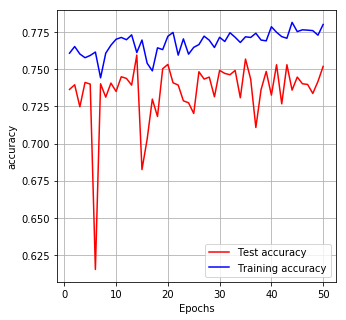

Test accuracy: 0.7519101123595505
Test loss: 0.7057929565652086


In [99]:
model_paras = model.history
x = list(range(1,len(model_paras.history['loss']) + 1))
plt.figure(figsize=(5,5))
plt.plot(x,model_paras.history['val_acc'],color = 'r',label = 'Test accuracy')
plt.plot(x,model_paras.history['acc'],color = 'b',label = 'Training accuracy')
plt.grid()
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.show()
# Final evaluation of the model
#scores = model.evaluate(x_test, y_test, verbose=0)
#print("Accuracy: %.2f%%" % (scores[1]*100))
score, acc = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy:', acc)
print("Test loss:", score)

Number of misclassified points  24.808988764044944
-------------------------------------------------- Confusion matrix --------------------------------------------------


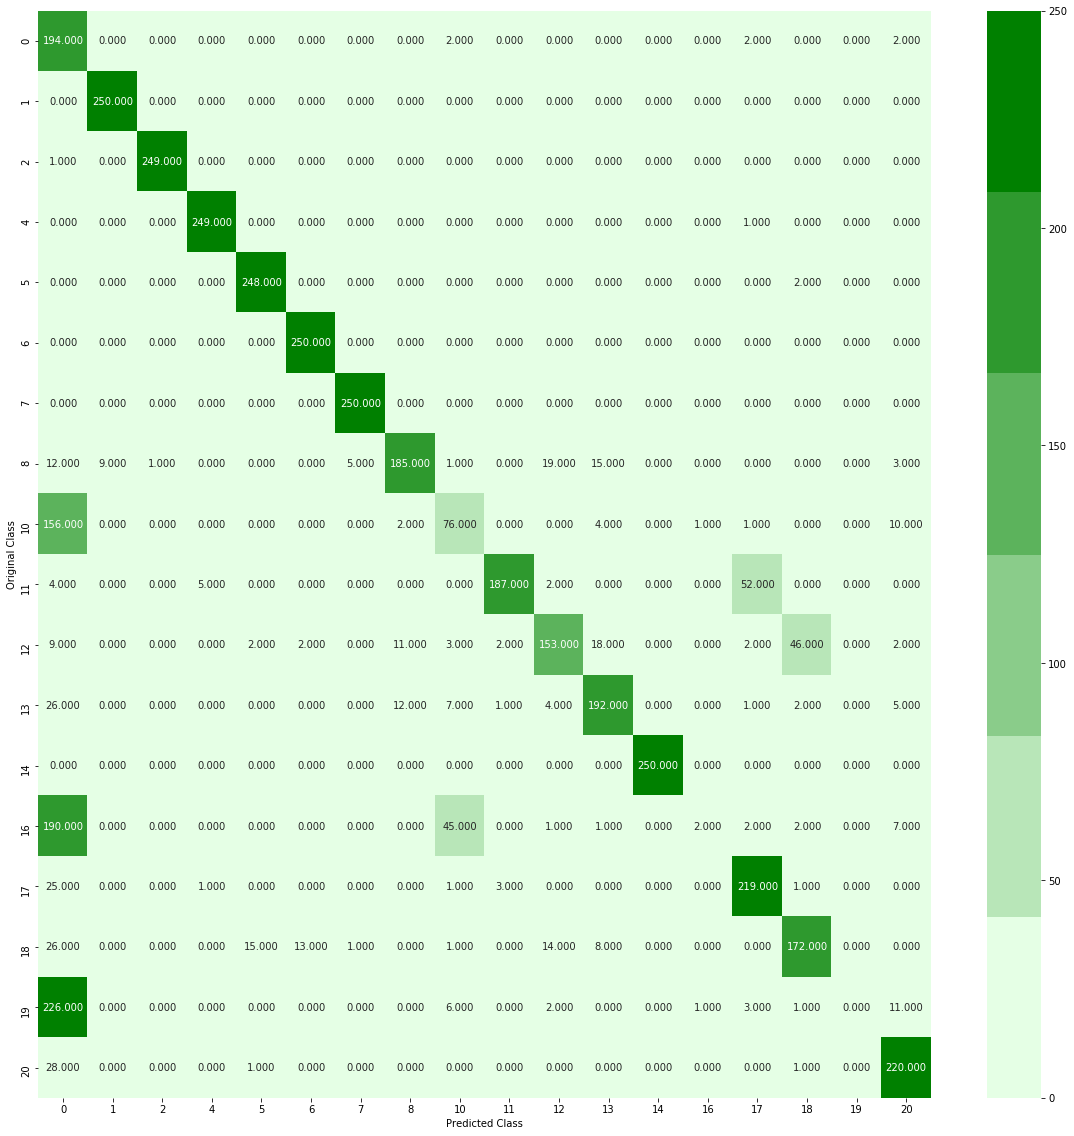

-------------------------------------------------- Precision matrix --------------------------------------------------


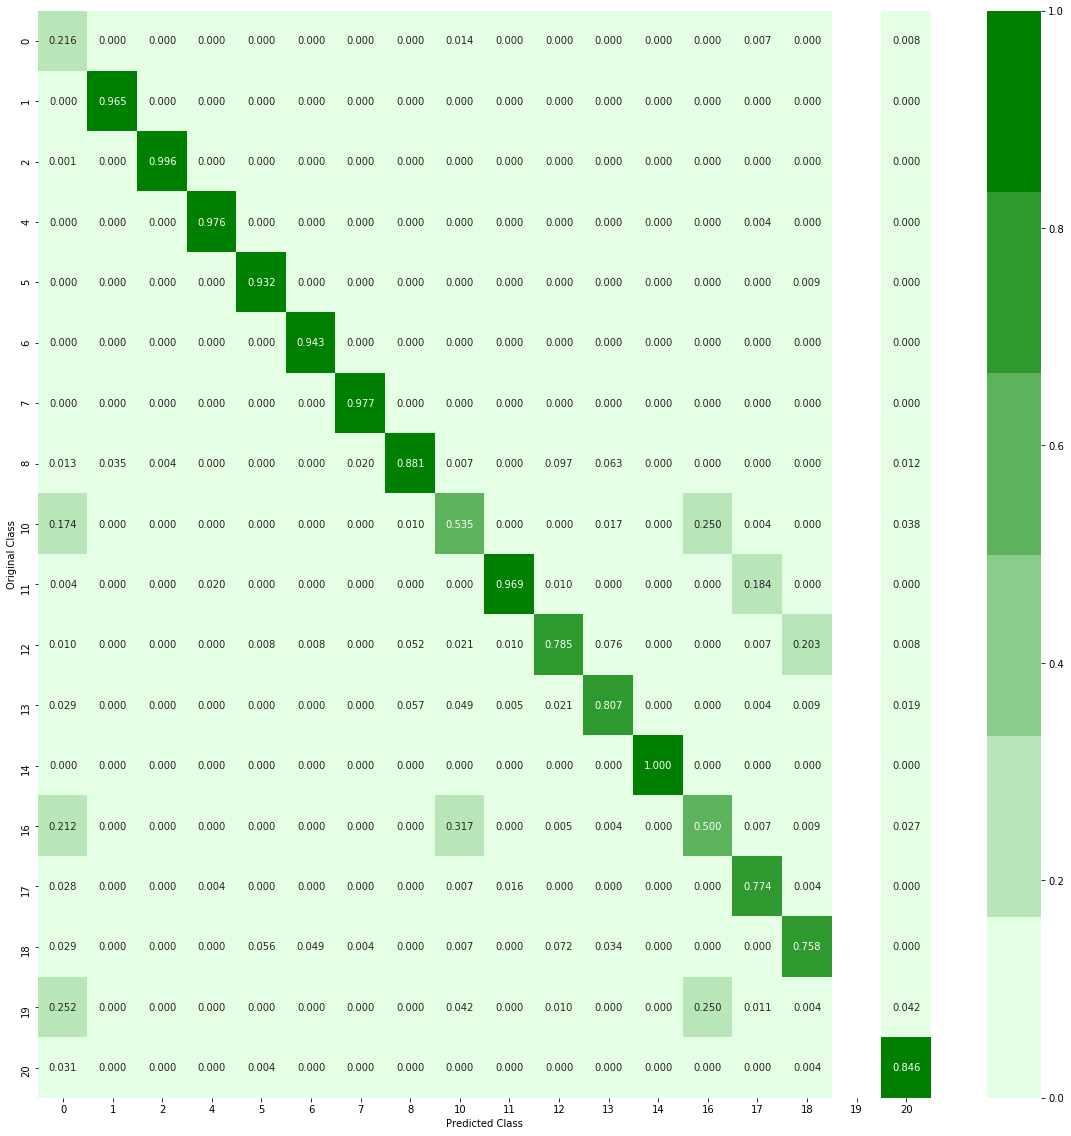

Sum of columns in precision matrix [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. nan  1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


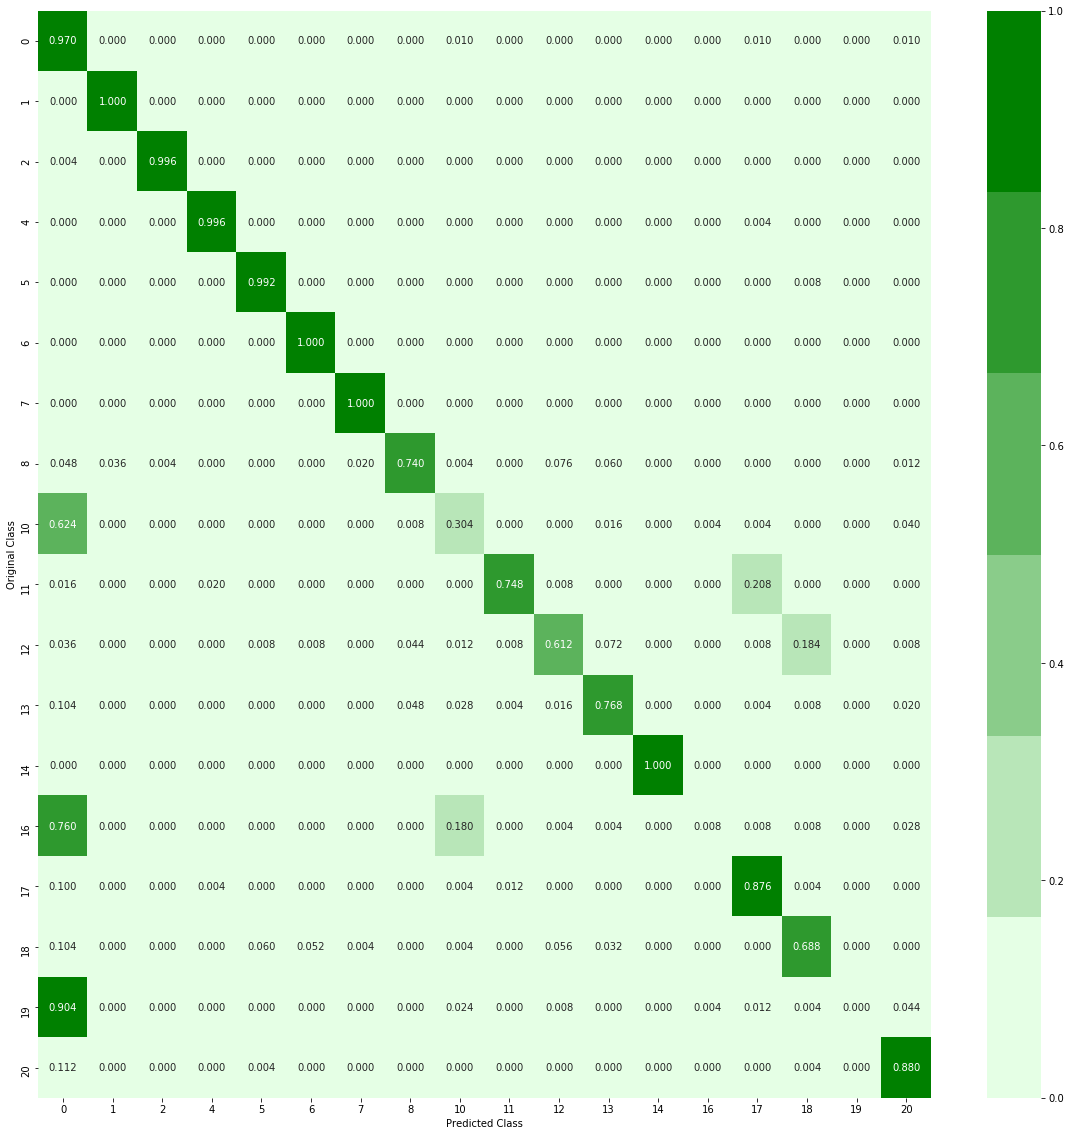

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [100]:

y = model.predict_proba(x_test)

plot_confusion_matrix(np.argmax(y_test,axis = 1),np.argmax(y,axis = 1))

# Model - 4

In [38]:
model = Sequential()
model.add(LSTM(128,input_shape= (52,20),return_sequences= True,activation = 'sigmoid'))
#model.add(LSTM(256,return_sequences= True))
model.add(LSTM(128,return_sequences= False,activation = 'sigmoid'))
#model.add(LSTM(64,return_sequences= False))
#model.add(Flatten())
#model.add(BatchNormalization())
#model.add(Flatten())
model.add(Dense(300))
#model.add(Dropout(0.5))
#model.add(Dense(128))
#model.add(Dense(64))
#model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(21,activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_35 (LSTM)               (None, 52, 128)           76288     
_________________________________________________________________
lstm_36 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_32 (Dense)             (None, 300)               38700     
_________________________________________________________________
dropout_18 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 21)                6321      
Total params: 252,893
Trainable params: 252,893
Non-trainable params: 0
_________________________________________________________________
None


In [41]:
model.fit(x_train, y_train, nb_epoch=100,verbose=2,batch_size=256,validation_data = (x_test,y_test))

Train on 9160 samples, validate on 4450 samples
Epoch 1/100
 - 7s - loss: 0.7379 - acc: 0.7377 - val_loss: 0.8321 - val_acc: 0.7218
Epoch 2/100
 - 7s - loss: 0.7763 - acc: 0.7274 - val_loss: 0.8938 - val_acc: 0.6989
Epoch 3/100
 - 7s - loss: 0.7900 - acc: 0.7201 - val_loss: 0.8688 - val_acc: 0.6942
Epoch 4/100
 - 7s - loss: 0.7579 - acc: 0.7334 - val_loss: 0.8358 - val_acc: 0.7108
Epoch 5/100
 - 7s - loss: 0.7644 - acc: 0.7322 - val_loss: 0.9059 - val_acc: 0.7047
Epoch 6/100
 - 7s - loss: 0.7521 - acc: 0.7356 - val_loss: 0.8643 - val_acc: 0.7117
Epoch 7/100
 - 7s - loss: 0.7560 - acc: 0.7303 - val_loss: 0.8834 - val_acc: 0.7004
Epoch 8/100
 - 7s - loss: 0.7512 - acc: 0.7373 - val_loss: 0.9338 - val_acc: 0.6861
Epoch 9/100
 - 8s - loss: 0.7518 - acc: 0.7354 - val_loss: 0.8184 - val_acc: 0.7270
Epoch 10/100
 - 8s - loss: 0.7279 - acc: 0.7451 - val_loss: 0.8476 - val_acc: 0.7182
Epoch 11/100
 - 8s - loss: 0.8338 - acc: 0.7087 - val_loss: 0.8993 - val_acc: 0.6838
Epoch 12/100
 - 8s - loss:

Epoch 97/100
 - 8s - loss: 0.6174 - acc: 0.7758 - val_loss: 0.7345 - val_acc: 0.7515
Epoch 98/100
 - 8s - loss: 0.6210 - acc: 0.7788 - val_loss: 0.7777 - val_acc: 0.7382
Epoch 99/100
 - 8s - loss: 0.8233 - acc: 0.7167 - val_loss: 0.7897 - val_acc: 0.7326
Epoch 100/100
 - 8s - loss: 0.6529 - acc: 0.7668 - val_loss: 0.7902 - val_acc: 0.7312


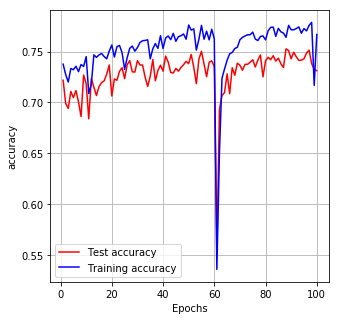

Test accuracy: 0.7312359550561798
Test loss: 0.7902427786558323


In [42]:
model_paras = model.history
x = list(range(1,len(model_paras.history['loss']) + 1))
plt.figure(figsize=(5,5))
plt.plot(x,model_paras.history['val_acc'],color = 'r',label = 'Test accuracy')
plt.plot(x,model_paras.history['acc'],color = 'b',label = 'Training accuracy')
plt.grid()
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.show()
# Final evaluation of the model
#scores = model.evaluate(x_test, y_test, verbose=0)
#print("Accuracy: %.2f%%" % (scores[1]*100))
score, acc = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy:', acc)
print("Test loss:", score)

Number of misclassified points  26.876404494382022
-------------------------------------------------- Confusion matrix --------------------------------------------------


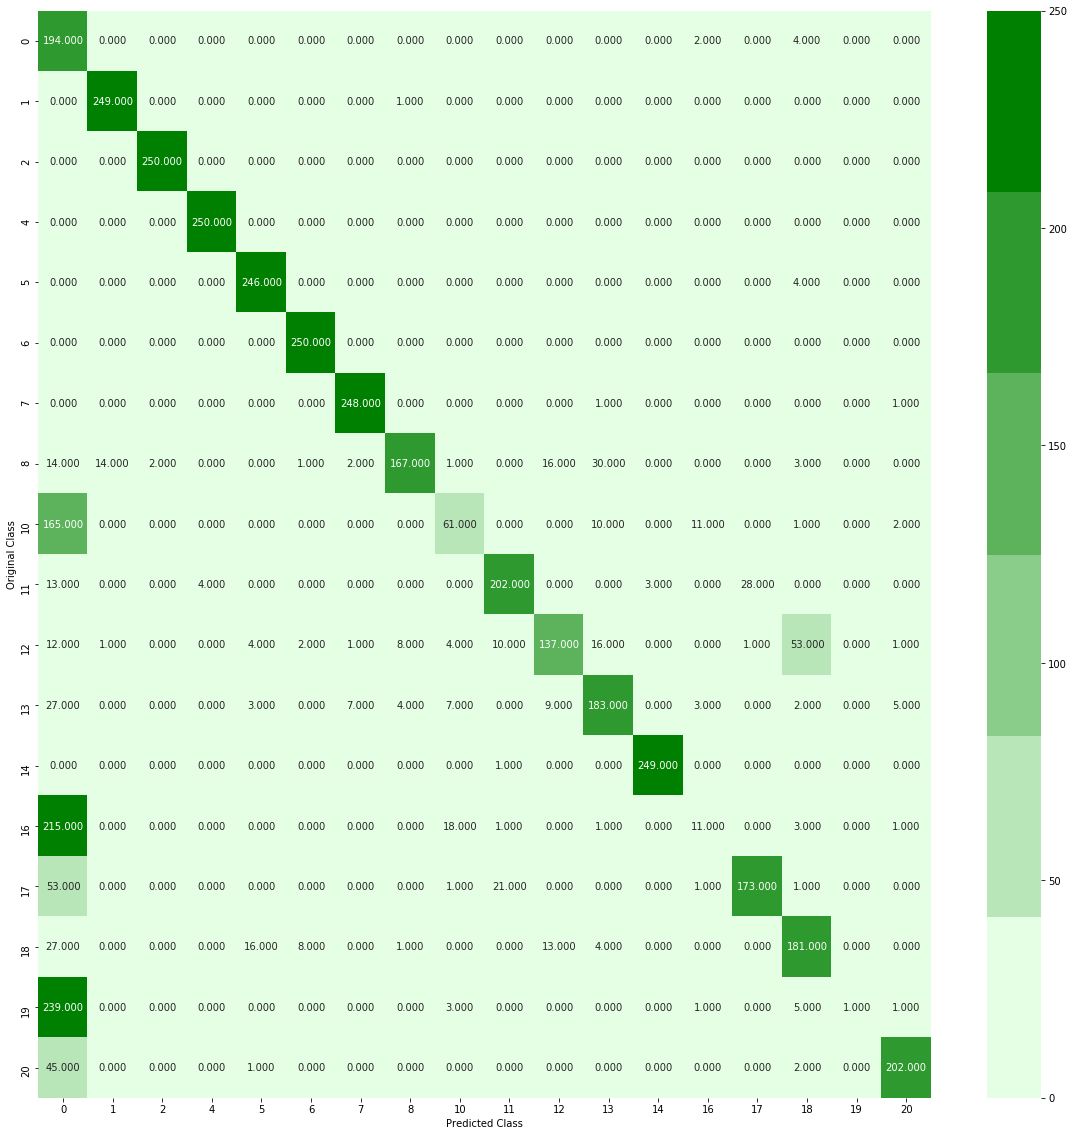

-------------------------------------------------- Precision matrix --------------------------------------------------


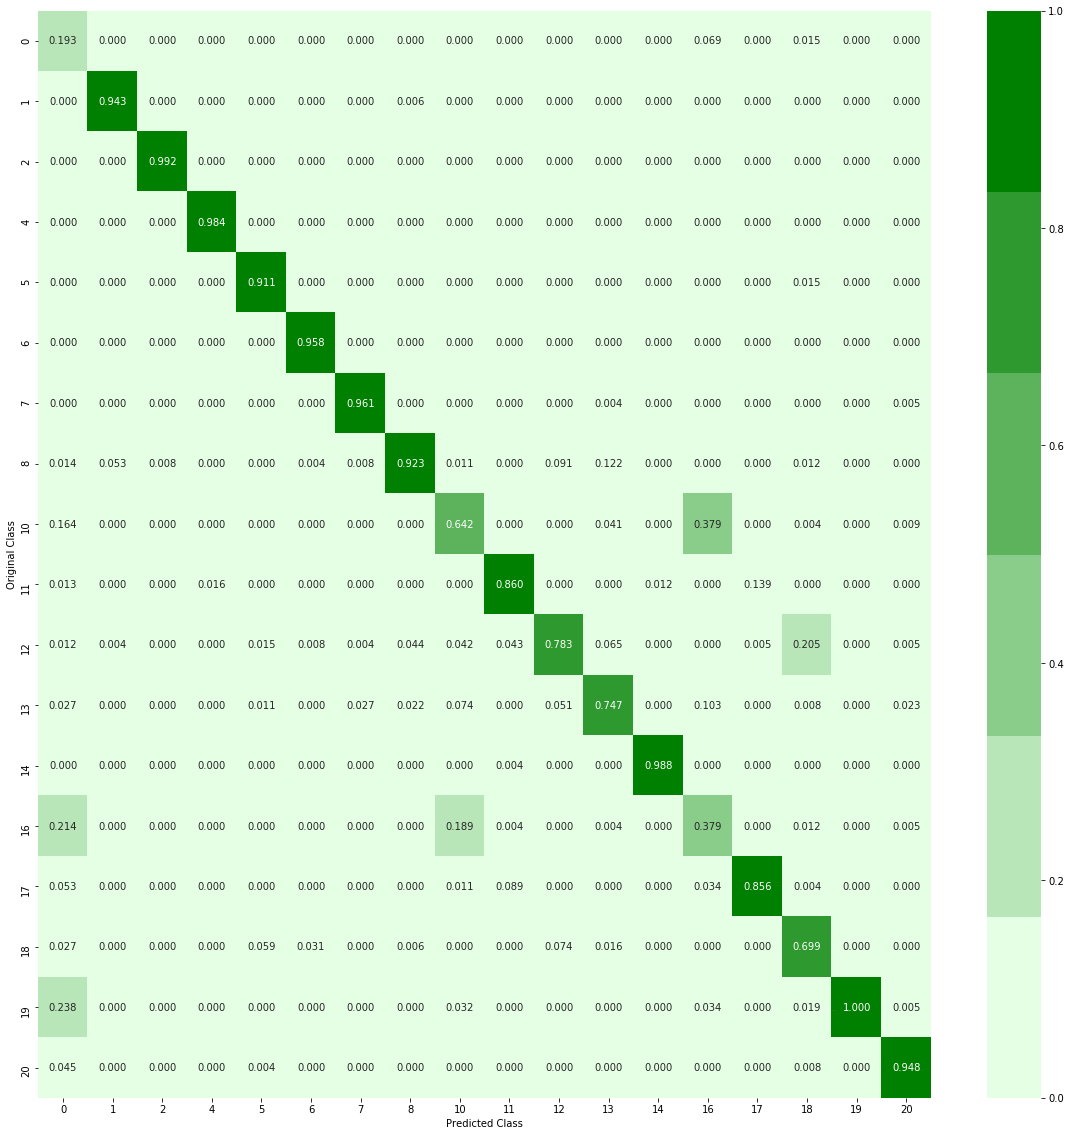

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


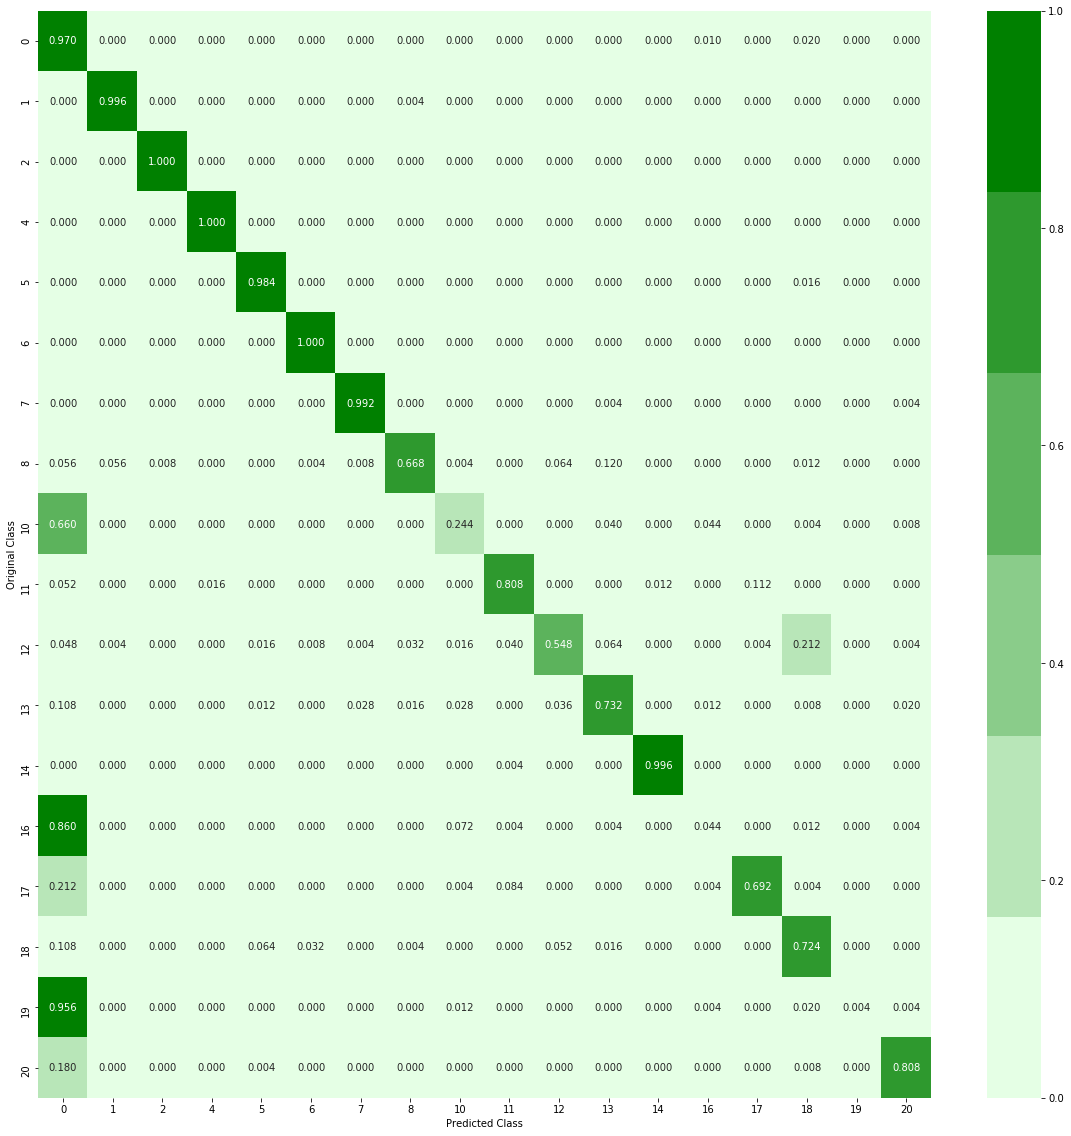

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [43]:

y = model.predict_proba(x_test)

plot_confusion_matrix(np.argmax(y_test,axis = 1),np.argmax(y,axis = 1))

# Machine Learning Models.
- Random Forest
- XgBoost   
Lets try these two classical models and see whether we get a better FDR score.

In [6]:
#converting the class labels to categorical values and removing unnecessary features from train, test and cv data.
y_train = tr['faultNumber']
y_test = ts['faultNumber']
y_cv = cv_['faultNumber']
tr.drop(['faultNumber','Unnamed: 0','simulationRun','sample','index'],axis=1,inplace=True)
ts.drop(['faultNumber','Unnamed: 0','simulationRun','sample','index'],axis =1,inplace=True)
cv_.drop(['faultNumber','Unnamed: 0','simulationRun','sample','index'],axis =1,inplace=True)

In [7]:
standard_scalar = StandardScaler()
train_norm = standard_scalar.fit_transform(tr)
test_norm = standard_scalar.transform(ts)
cv_norm = standard_scalar.transform(cv_)

In [8]:
# model fitting and hyperparameter tuning using gridsearch
x_cfl=RandomForestClassifier()
#weights = np.linspace(0.05, 0.95, 20)
prams={
     'n_estimators':[100,200,500],
     'max_depth':[15,20,25,30,35]#,'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    
    
}
model=GridSearchCV(x_cfl,param_grid=prams,verbose=10,n_jobs=-1,scoring='f1_micro',cv=3)
model.fit(train_norm,y_train)
print("Best estimator is", model.best_params_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done  27 out of  45 | elapsed: 26.6min remaining: 17.7min
[Parallel(n_jobs=-1)]: Done  32 out of  45 | elapsed: 31.3min remaining: 12.7min
[Parallel(n_jobs=-1)]: Done  37 out of  45 | elapsed: 38.0min remaining:  8.2min
[Parallel(n_jobs=-1)]: Done  42 out of  45 | elapsed: 41.3min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 45.1min finished


Best estimator is {'max_depth': 35, 'n_estimators': 500}


In [10]:

clf = RandomForestClassifier(n_jobs=-1,n_estimators= 500,max_depth=35)
clf.fit(train_norm, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=35, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

Number of misclassified points  15.594382022471908
-------------------------------------------------- Confusion matrix --------------------------------------------------


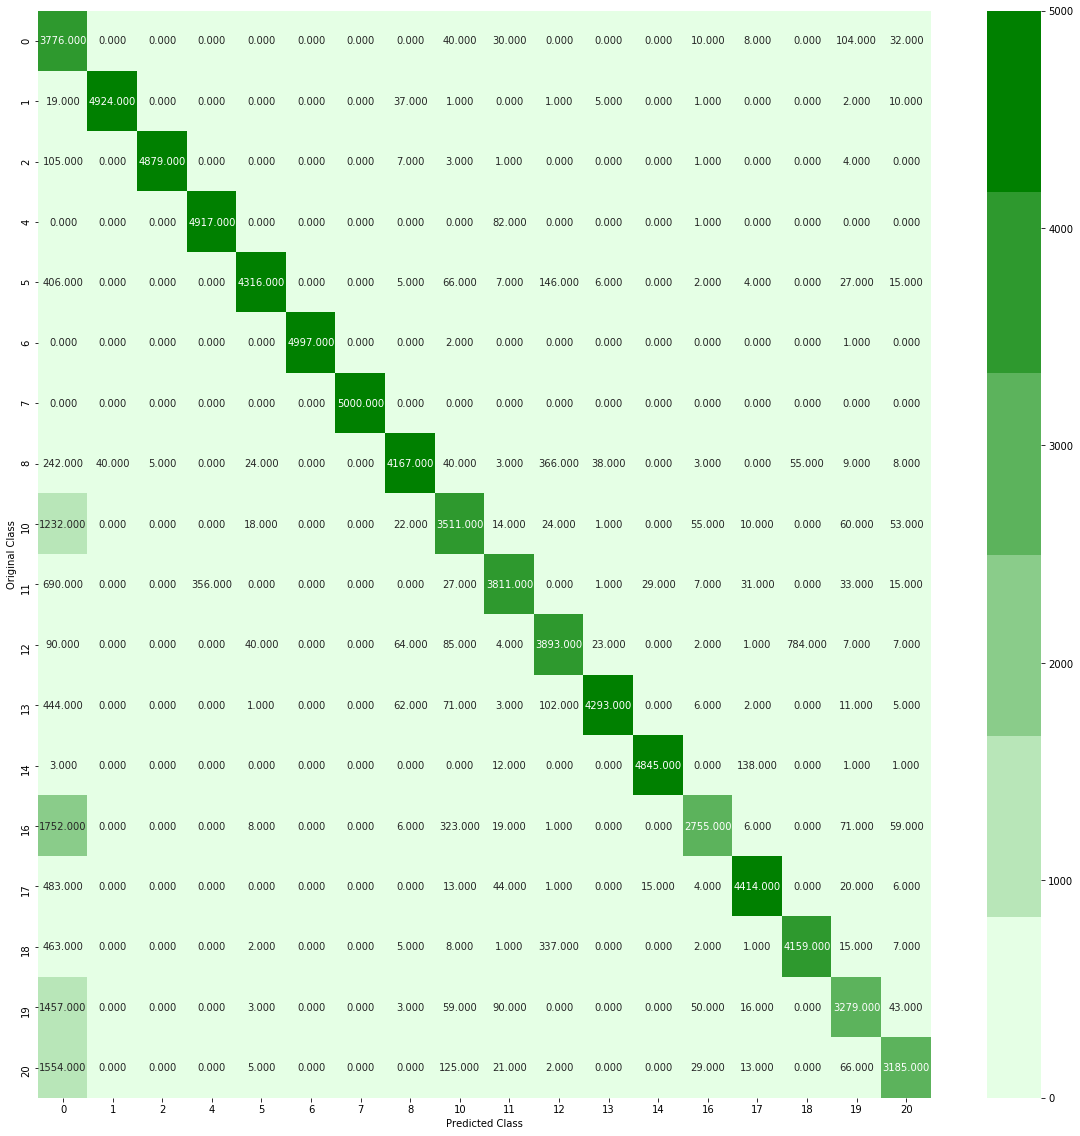

-------------------------------------------------- Precision matrix --------------------------------------------------


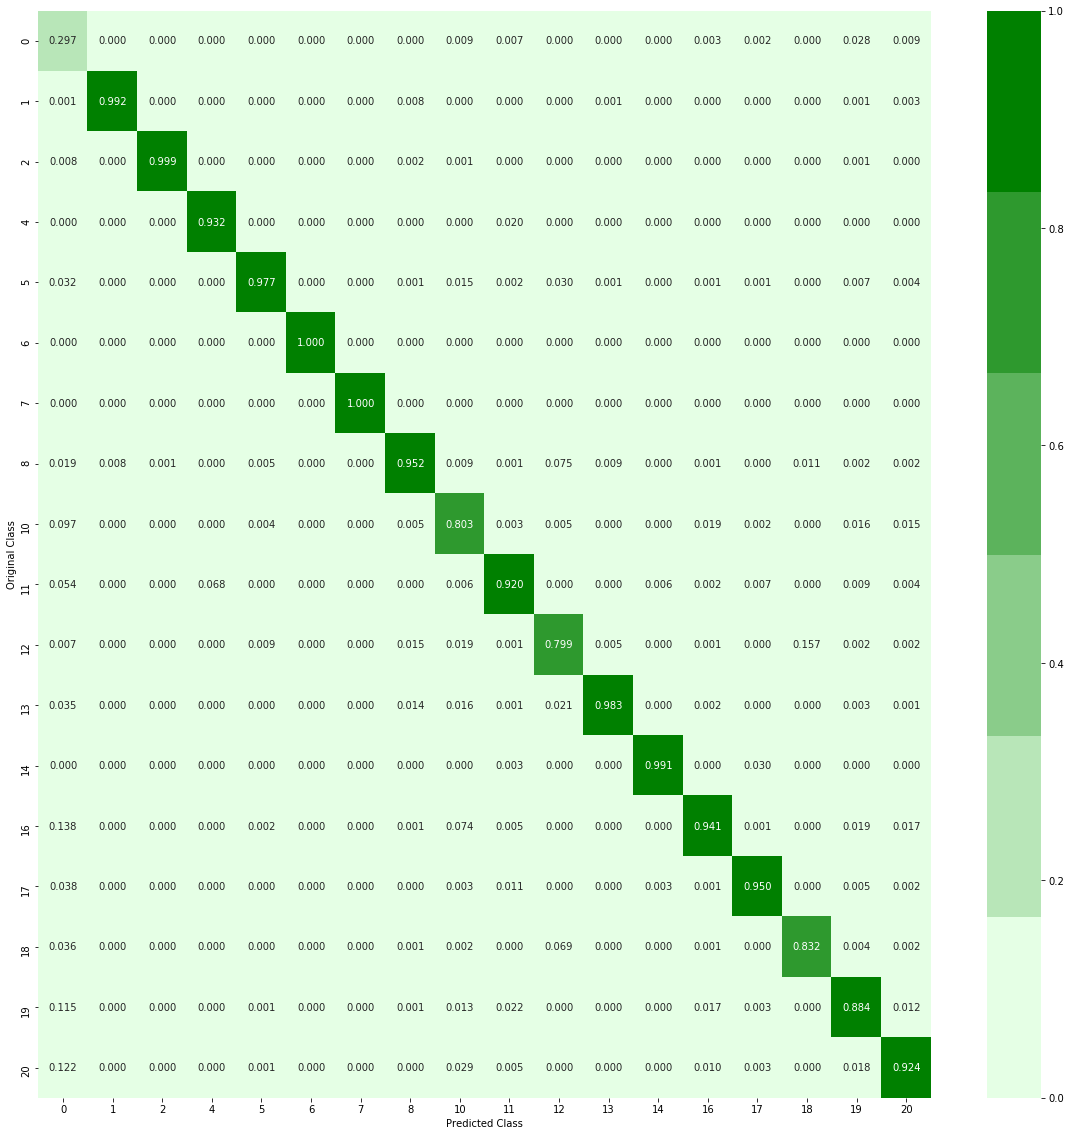

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


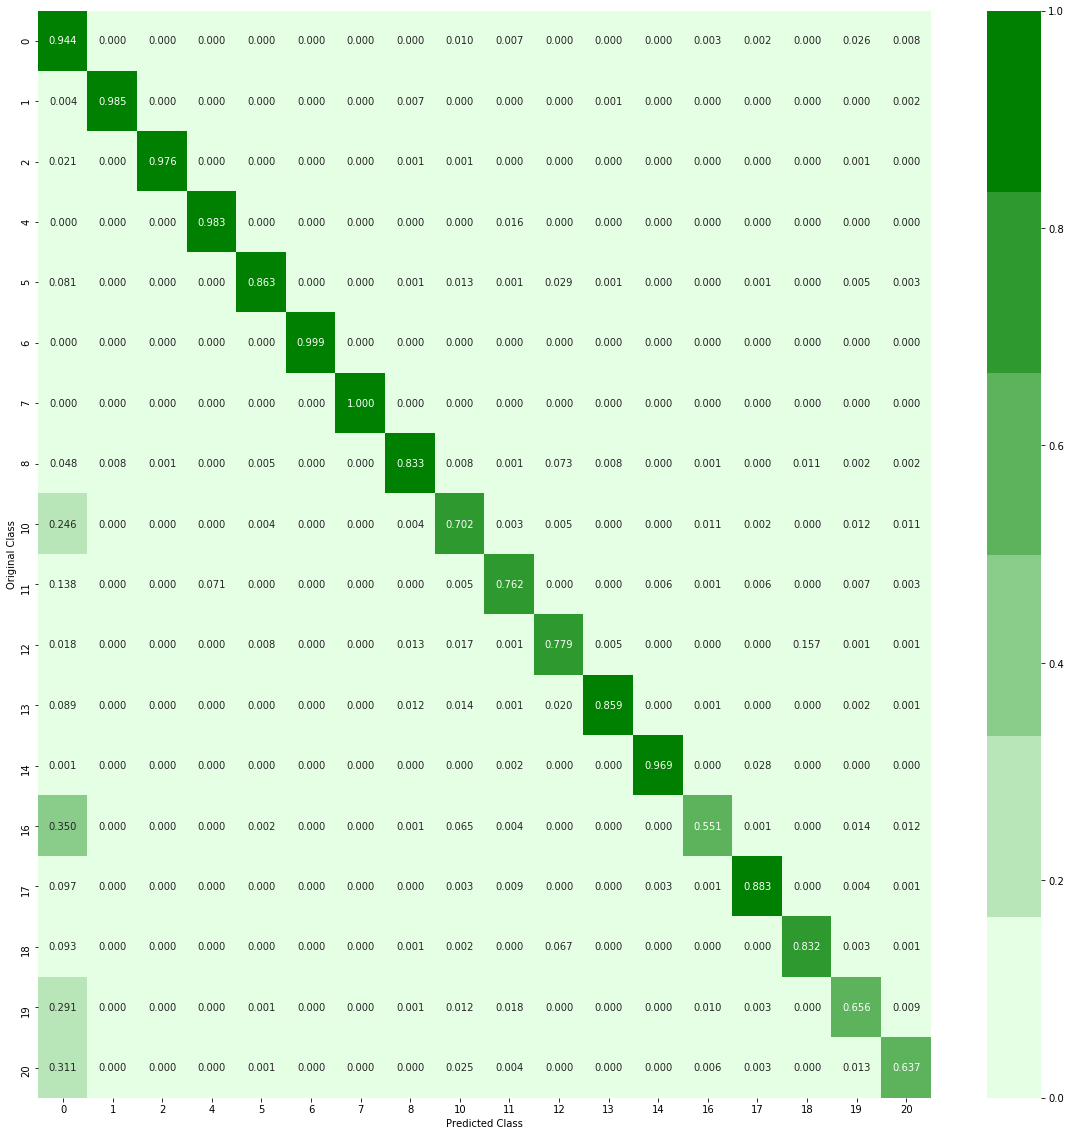

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [11]:
plot_confusion_matrix(y_test, clf.predict(test_norm))

- FDR for Random Forest = 0.8986

In [9]:
# model fitting and hyperparameter tunning using gridsearch
x_cfl=xgb.XGBClassifier(objective="multi:softprob")

prams={
    
     'n_estimators':[100,200,500],
     'max_depth':[5,10,15,20,30,35]
}
model=GridSearchCV(x_cfl,param_grid=prams,verbose=10,n_jobs=-1,scoring='f1_micro',cv=3)
model.fit(train_norm,y_train)
print("Best estimator is", model.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 45.0min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 89.6min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 214.2min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 571.5min
[Parallel(n_jobs=-1)]: Done  37 out of  54 | elapsed: 1240.7min remaining: 570.0min
[Parallel(n_jobs=-1)]: Done  43 out of  54 | elapsed: 1441.1min remaining: 368.7min
[Parallel(n_jobs=-1)]: Done  49 out of  54 | elapsed: 1657.0min remaining: 169.1min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed: 1771.1min finished


Best estimator is {'max_depth': 20, 'n_estimators': 500}


In [11]:
clf=xgb.XGBClassifier(objective="multi:softprob",n_estimators=500,max_depth=20,n_jobs=-1)
clf.fit(train_norm, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=20, min_child_weight=1, missing=None, n_estimators=500,
              n_jobs=-1, nthread=None, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

Number of misclassified points  8.762921348314606
-------------------------------------------------- Confusion matrix --------------------------------------------------


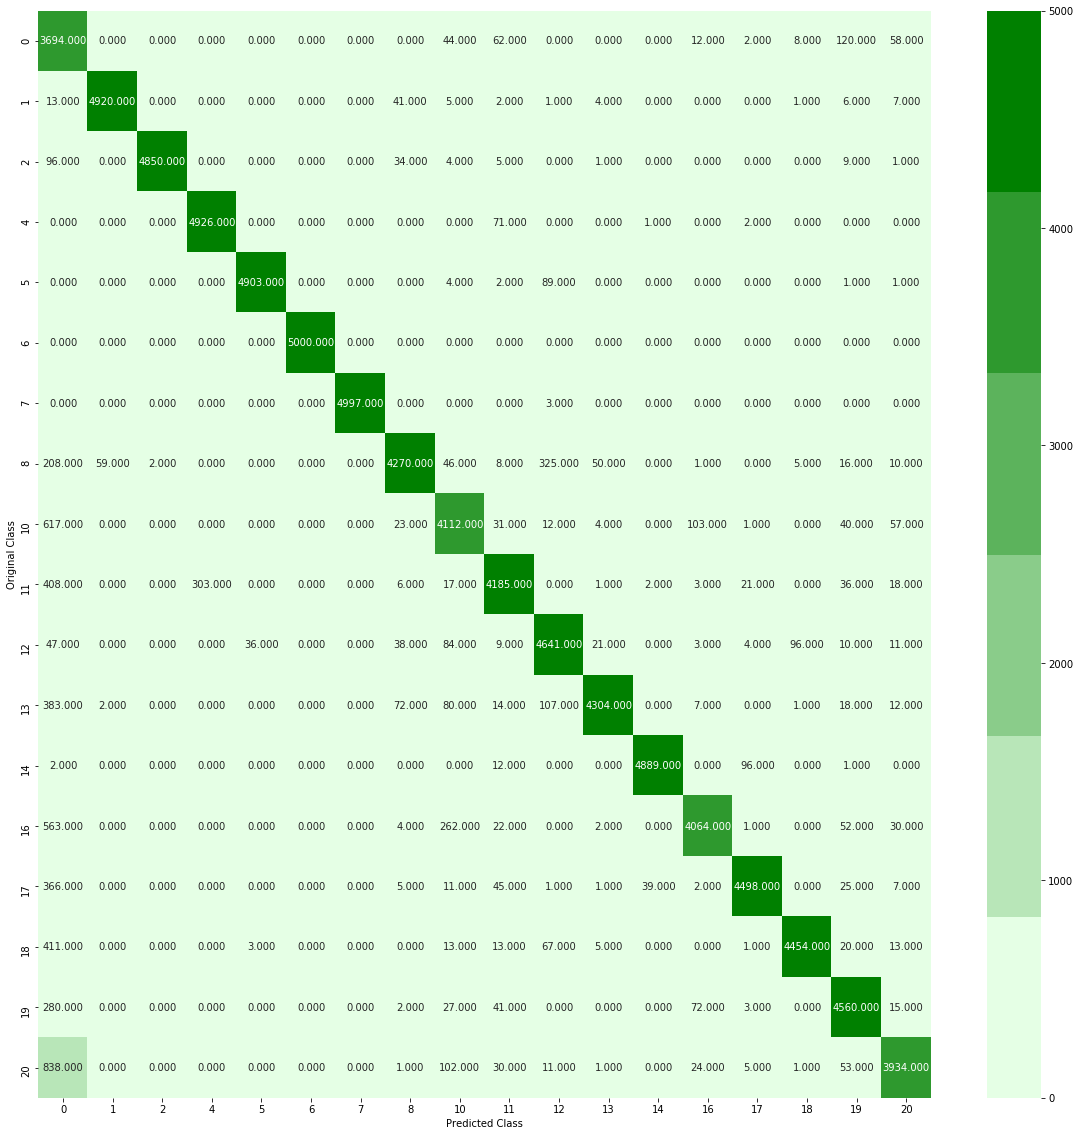

-------------------------------------------------- Precision matrix --------------------------------------------------


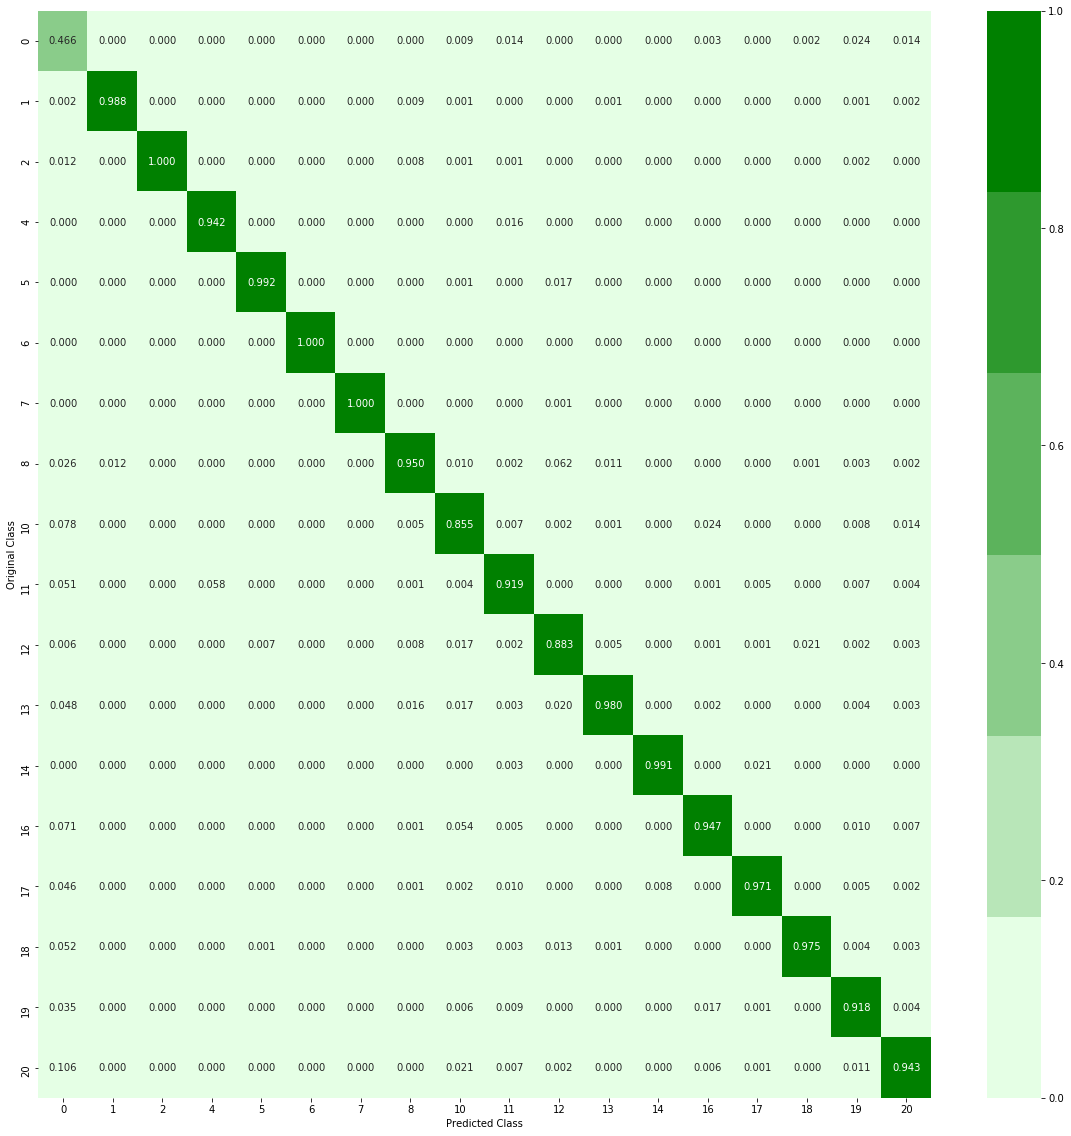

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


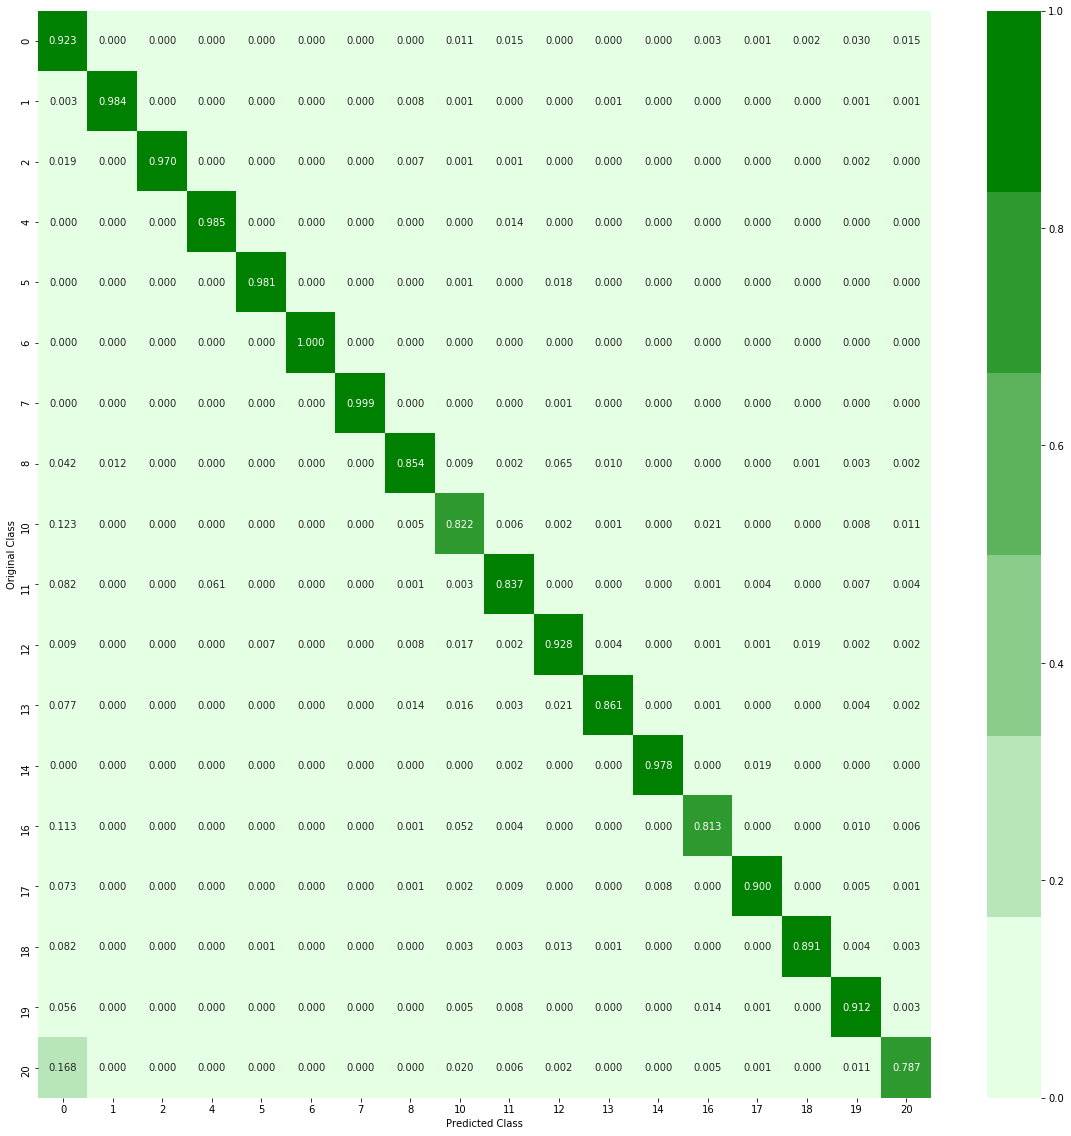

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [14]:
y_pred_test = clf.predict(test_norm)
plot_confusion_matrix(y_test, y_pred_test)

- FDR for XgBoost is 0.9288

# Results:

In [12]:
table = PrettyTable()
table.field_names = ['Model', 'Average FDR']
table.add_row(['Model - 1', 0.8037])
table.add_row(['Model - 2', 0.8023])
table.add_row(['Model - 3', 0.77])
table.add_row(['Model - 4', 0.8203])
table.add_row(['Random Forest', 0.8986])
table.add_row(['XgBoost', 0.9288])
print(table)

+---------------+-------------+
|     Model     | Average FDR |
+---------------+-------------+
|   Model - 1   |    0.8037   |
|   Model - 2   |    0.8023   |
|   Model - 3   |     0.77    |
|   Model - 4   |    0.8203   |
| Random Forest |    0.8986   |
|    XgBoost    |    0.9288   |
+---------------+-------------+


# Conclusion:

- For Deep Learning LSTM model -4 gives the best Avearge FDR. The FDR can be increasd further by training the model with more number of points and doing hyper parameter tunning like different learning rates, optimizers and units in the dense layers. Also fault 0 can be removed to increase the FDR further. 
- By using Classical Machine learning Algorithms, Xgboot gives us a FDR of 0.92 which is far better than the Deep learning Models. Random Forest too gives a FDR of 0.89866 which is far better as compared to the Deep learning models.
- Classical Machine learning models performs well as compared to Deep learning models.

# Procedure: 

 
- First we read the train and test dataset. Through EDA it was observed that both train and test datasets are balanced.
- It was observed that both the train and test datasets had no NaN values.
- Imputation techniques like median, mean and most frequent were used.
- Since the training and test datasets where large, both train and test datasets where sampled and stored as .csv files for further use. Also a CV dataset was created from the original Train dataset.
- Different LSTM DL models were trained to find the model with the best FDR score.
- Next we tried RF and XgBoost models to chech whether classical ML models can provide with better FDR score.
- Results of all the models are present in the table above.

# END